# Расчет вертикального прогиба балки

## Исходные данные
### Задание

<strong>К-3-08:</strong> Дана консольная балка с переменным поперечным сечением, показанная на рисунке ниже.
<img src="./pics/balka.png" width=300px>

Дифференциальное уравнение для вертикального прогиба имеет вид:

\begin{equation}
\frac{d^4y}{dx^4} = - \frac{2}{I} \frac{dI}{dx}\cdot \frac{d^3y}{dx^3} - \frac{1}{I} \frac{d^2I}{dx^2}\cdot \frac{d^2y}{dx^2} + \frac{\omega}{EI},
\end{equation}

где $x$ - горизонтальное расстояние вдоль балки, $y$ - вертикальный прогиб, $l$ - длина балки, $M$ - изгибающий момент, $E$ - модуль Юнга, $I$ - момент инерции, $P$ - нагрузка на балку.

Начальные условия:

$y(0) = y'(0) = 0$,<br/>
$y''(0) = \frac{Pl}{75}\cdot 10^{-7}$,<br/>
$y'''(0) = \frac{P \cdot 3.8}{75}\cdot 10^{-7}$

Значения нагрузки на балку будет менять в диапазоне $500 \div 1000$ с шагом $100$. При этом значение $P_0 = 750$.

Значение длины балки: $l = 50\cdot x^*$, где $x^*$ - корень уравнения на промежутке $[1, 4]$:
\begin{equation}
\int_0^{20} \frac{e^{-0.9z}}{z+x}dz = 0.1957981\cdot x
\end{equation}

### Найти
Вычислить $y(l)$ для различных значений $P$. Построить сплайн по значениям $y(l)$ в зависимости от $P$ и с его помощью оценить $y(l)$ для $P_0$. <br/>
Оценить погрешность результата и влияние на точность погрешности исходных данных.

## Решение

### Анализ исходного уравнения

Рассмотрим последнее слагаемое исходного дифференциального уравнения:

\begin{equation}
\omega = -\frac{d^2M}{dx^2}
\end{equation}
\begin{equation}
M(x) = -P \cdot (l - x)
\end{equation}

Можно заметить, что $\frac{d^2M}{dx^2} = 0$ при $\forall x$, а значит и $\frac{\omega}{EI} = 0$ при $\forall x$.

Таким образом дифференциально уравнение преобразуется к виду:
\begin{equation}
\frac{d^4y}{dx^4} = - \frac{2}{I} \frac{dI}{dx}\cdot \frac{d^3y}{dx^3} - \frac{1}{I} \frac{d^2I}{dx^2}
\end{equation}

Рассмотрим функцию $I(x)$ и найдем ее производные:
\begin{equation}
I(x) = 5(1 + 4e^{-\frac{6x}{l}})
\end{equation}

\begin{equation}
\frac{dI(x)}{dx} = -\frac{120}{l}e^{-\frac{6x}{l}}
\end{equation}

\begin{equation}
\frac{d^2I(x)}{dx^2} = \frac{720}{l}e^{-\frac{6x}{l}}
\end{equation}

Все найденные значения можно подставить в исходное уравнение:

\begin{equation}
\frac{d^4y}{dx^4} = \frac{2}{5(1 + 4e^{-\frac{6x}{l}})} \cdot \frac{120}{l}e^{-\frac{6x}{l}} \cdot \frac{d^3y}{dx^3} - 
\frac{1}{5(1 + 4e^{-\frac{6x}{l}})} \cdot \frac{720}{l}e^{-\frac{6x}{l}} \cdot \frac{d^2y}{dx^2}
\end{equation}

### Нахождение длины балки

Для нахождения корней функция $F(x)$ с начальным приближением $x = 2.5$ будем использовать функцию <code>optimize.fsolve</code> из пакета <code>scipy</code>, являющуюся оберткой над алгоритмами <code>hybrd</code> и <code>hybrj</code> из библиотеки <code>MINPACK</code> для языка программирования <code>FORTRAN</code>. При интегрировании будем использовать функцию <code>integrate.quad</code> из пакета <code>scipy</code>, использующую метод из библиотеки <code>QUADPACK</code> для языка программирования <code>FORTRAN</code>.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
from scipy import interpolate
from scipy import optimize
from matplotlib import rc
from matplotlib.ticker import FormatStrFormatter
font = {'family': 'Arial', 'weight': 'normal'}
rc('font', **font)

In [2]:
def fun(x: float):
    def inner(z: float):
        return math.exp(-0.9 * z)/(z + x)
    return integrate.quad(inner, 0, 20)[0] - 0.1957981 * x;

In [3]:
x_star, = optimize.fsolve(fun, (4 - 1) / 2)
print('x* = {x}'.format(x=x_star))

l = 50 * x_star
print('Длина балки l = {l}'.format(l=l))

x* = 1.9996955172047453
Длина балки l = 99.98477586023726


### Начальные условия

Запишем начальные условия:

In [4]:
def get_y0(p: int):
    y0_1 = 0
    y0_2 = 0
    y0_3 = p * l / 75 * 10 ** (-7)
    y0_4 = p * 3.8 / 75 * 10 ** (-7)
    return np.array([y0_1, y0_2, y0_3, y0_4])

Запишем значения нагрузки на балку:

In [5]:
def get_p():
    return np.arange(500, 1000 + 1, 100)
p0 = 750

### Решение дифференциального уравнения

Перейдем к решению дифференциального уравнения. Для этого произведем следующшие замены:

\begin{equation}
x_1(t) = y(t),\ \ x_2(t) = y'(t),\ \ x_3(t) = y''(t),\ \ x_4(t) = y'''(t).
\end{equation}

С их помощью исходное дифференциальное уравнение сводится к системе дифференциальных уравнений первого порядка:

\begin{equation}
\begin{pmatrix}
    x'_1(t) \\
    x'_2(t) \\
    x'_3(t) \\
    x'_4(t) \\
\end{pmatrix} =
\begin{pmatrix}
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & - \frac{1}{I} \frac{d^2I}{dx^2} & - \frac{2}{I} \frac{dI}{dx} \\
\end{pmatrix}
\cdot
\begin{pmatrix}
    x_1(t) \\
    x_2(t) \\
    x_3(t) \\
    x_4(t) \\
\end{pmatrix}
\end{equation}

In [6]:
def evaluate(y: np.array, t: float, a: float, b: float):
    i = a * (1 + 4 * math.exp(-b * t/l))
    di1 = 4 * a * (-b) * math.exp(-b * t/l) / l
    di2 = 4 * a * (-b) * (-b) * math.exp(-b * t/l) / l
    y41 = -1 * di2 / i
    y42 = -2 * di1 / i
    y4 = y41 * y[2] + y42 * y[3]
    return np.array([y[1], y[2], y[3], float(y4)])

Будем решать дифференциальное уравнение в диапазоне $(l-5) \div (l+5)$ с шагом $0.01$:

In [7]:
t0 = l - 5
tn = l + 5
th = 0.01
t = np.arange(t0, tn, th)

Найдем значения $y(t)$ для заданных значений $P$. 

In [8]:
values = []

for p in get_p():
    y0 = get_y0(p)
    res, info = integrate.odeint(evaluate, y0, t, args=(5,6), atol=1e-8, full_output=True)
    y = np.transpose(res)[0]
    values.append(y)

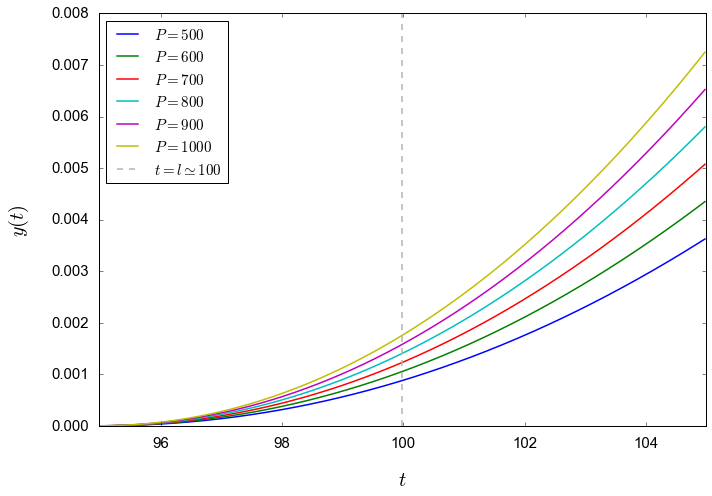

In [9]:
axes = plt.figure(figsize=(10,7)).gca()

for i in range(len(get_p())):
    axes.plot(t, values[i], linewidth=1.5, label='$P = {p}$'.format(p=get_p()[i]))
    
axes.plot([l, l], [0, 0.008], color='0.7', linewidth=1.5, linestyle='--', label='$t = l \simeq {l}$'.format(l=math.ceil(l)))
axes.legend(loc='upper left', fontsize=15)
axes.set_xlabel('$t$', fontsize=20, labelpad=20)
axes.set_ylabel('$y(t)$', fontsize=20, labelpad=20)
axes.tick_params(labelsize=15, pad=10)
axes.set_xlim([l-5, l+5])
#plt.title('$y(t)$ для различных значений $P$', fontsize=20)
plt.tight_layout()
plt.savefig('./pics/p.png')
plt.show()

### Зависимость значения $y(l)$ от $P$

Найдем значения $y(l)$ при заданных значениях $P$, для этого интерполируем полученные зависимости $y(t)$ и получим функцию $f(t)$:

In [10]:
p_interps = np.array([])
l_values = []

for i in range(len(values)):
    p_interp = interpolate.interp1d(t, values[i])
    p_interps = np.append(p_interps, p_interp)
    
    l_value = p_interp(l)
    l_values.append(l_value)
    
    print('P = {p}, f(l) = {value}'.format(p=get_p()[i], value=l_value))

P = 500, f(l) = 0.0008780244321001274
P = 600, f(l) = 0.001053631969430215
P = 700, f(l) = 0.0012292400048566508
P = 800, f(l) = 0.0014048482322263783
P = 900, f(l) = 0.0015804564443902172
P = 1000, f(l) = 0.0017560645121702462


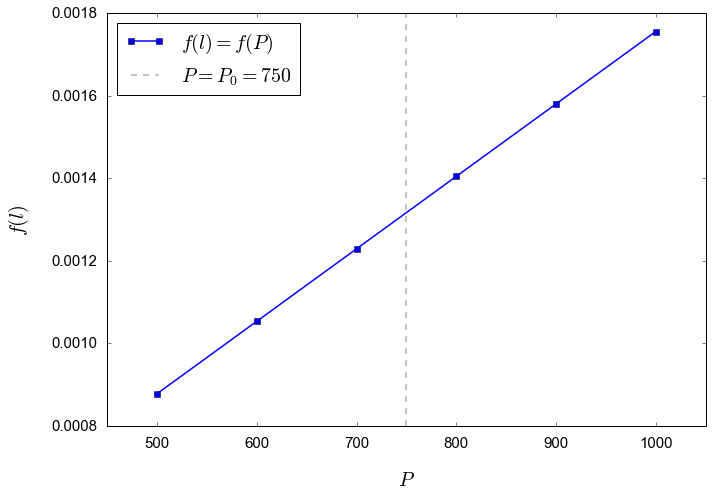

In [11]:
axes = plt.figure(figsize=(10,7)).gca()
axes.plot(get_p(), l_values, linewidth=1.5, marker='s', label='$f(l) = f(P)$')
axes.plot([p0, p0], [0.0008, 0.0018], linewidth=1.5, color='0.7', linestyle='--', label='$P = P_0 = {p0}$'.format(p0=p0))
axes.legend(loc='upper left', fontsize=20)
axes.set_xlabel('$P$', fontsize=20, labelpad=20)
axes.set_ylabel('$f(l)$', fontsize=20, labelpad=20)
axes.tick_params(labelsize=15, pad=10)
axes.set_xlim([450,1050])
#axes.set_title('Зависимость значения $f(l)$ от $P$', fontsize=20)
plt.tight_layout()
plt.savefig('./pics/l.png')
plt.show()

Построем сплайн $S(P)$ по полученным значениям и найдем искомое значение $S(P) = y(l)$ при $P = P_0 = 750$:

In [12]:
l_interp = interpolate.interp1d(get_p(), l_values, kind='cubic')
l_p0 = l_interp(p0)
print('P = {p}, S(P) = {value}'.format(p=p0, value=l_p0))

P = 750, S(P) = 0.001317044109707616


## Анализ влияния погрешности начальных условий на решение

Влияние погрешностей начальных условий будет анализировать при помощи измениния коэффициентов в функции $I(x)$:
\begin{equation}
I(x) = \alpha \cdot(1 + 4e^{-\frac{\beta\cdot x}{l}})
\end{equation}

Коэффициенты $\alpha$ и $\beta$ будем варьировать в следующих пределах с шагом $h = 0.01$:<br/>
\begin{equation}
\alpha = \alpha_0 \pm 0.1\cdot \alpha_0 = 5 \pm 0.5 = 4.5 \div 5.5
\end{equation}
\begin{equation}
\beta = \beta_0 \pm 0.1\cdot \beta_0 = 6 \pm 0.6 = 5.4 \div 6.6
\end{equation}

При этом возьмем $P = P_0 = 750$.

In [13]:
a0 = 5
b0 = 6
h = 0.01
a = np.arange(0.9 * a0, 1.1 * a0 + h, h)
b = np.arange(0.9 * b0, 1.1 * b0 + h, h)

g = np.meshgrid(a, b, indexing='ij')

values = []

for alpha in a:
    tmp = []
    for beta in b:
        y0 = get_y0(p0)
        res = integrate.odeint(evaluate, y0, t, args=(alpha,beta), atol=1e-8)
        y = np.transpose(res)[0]
        p_interp = interpolate.interp1d(t, y)
        l_value = p_interp(l)
        tmp.append(np.abs((l_value - l_p0)))
        
    values.append(tmp)

values = np.array(tmp)        

Для оценки влияния параметра на решение введем функцию $\varepsilon(a, b)$, равную модулю разности найденного значения $y_{\alpha_0\beta_0}(l) = S(P_0)$ и значения $y_{ab}(l)$, полученного при подстановке в уравнение $I(x)$ коэффициентов $\alpha = a$ и $\beta = b$:

\begin{equation}
\varepsilon(a, b) = |\ y_{\alpha_0\beta_0}(l) - y_{ab}(l)\ |
\end{equation}

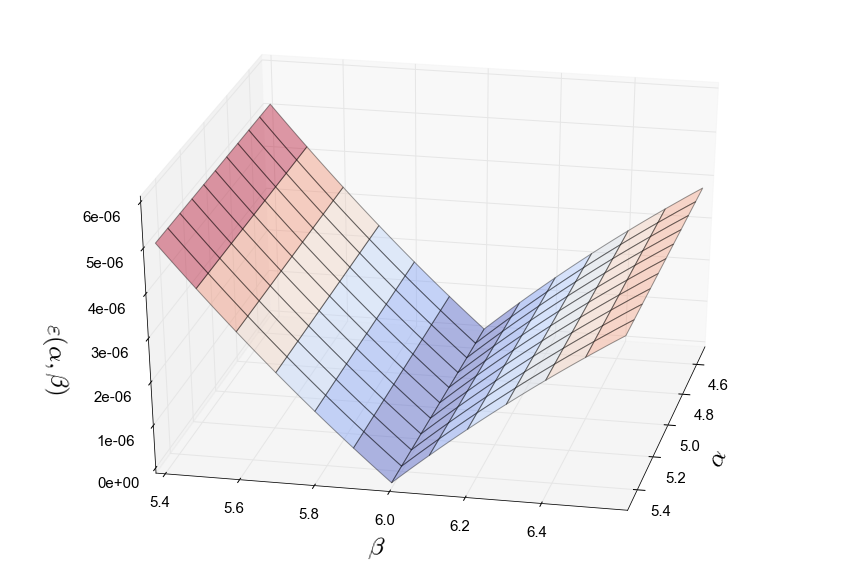

In [14]:
axes = plt.figure(figsize=(12,8)).gca(projection='3d')
axes.plot_surface(g[0], g[1], values, alpha=0.4, cmap=cm.coolwarm)
axes.view_init(elev=30., azim=12)
axes.zaxis.set_major_formatter(FormatStrFormatter('%.0e', ))
axes.set_xlabel(r'$\alpha$', fontsize=25, labelpad=20)
axes.set_ylabel(r'$\beta$', fontsize=25, labelpad=25)
axes.set_zlabel(r'$\varepsilon(\alpha, \beta)$', fontsize=25, labelpad=35)
axes.set_xlim(min(a), max(a))
axes.set_ylim(min(b), max(b))
axes.tick_params(labelsize=15, pad=10)
axes.tick_params('z', labelsize=15, pad=15)
#axes.set_title(r'Зависимость $\varepsilon$ от различных значений $a$ и $b$', fontsize=20)
plt.tight_layout()
plt.savefig('./pics/ab.png')
plt.show()

Из построенного графика видно, что варьирование параметра $\alpha$ в выбранном диапазоне имеет слабое влияение на итоговый результат, в то время как даже небольшое возмущение параметра $\beta$ в аналогичном диапазоне приводит к изменению итогового результата.